In [86]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import math

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=';')
df["quality_binary"] = (df["quality"] >= 7).astype(int)

In [87]:
X = df.drop(columns=["quality", "quality_binary"])
y = df["quality_binary"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [89]:
class FireflyOptimizerFast:
    def __init__(self, n_fireflies=20, max_iter=40, alpha=0.25, beta0=1.0, gamma=1.0):
        self.n_fireflies = n_fireflies
        self.max_iter = max_iter
        self.alpha = alpha
        self.beta0 = beta0
        self.gamma = gamma

    def decode(self, x):
        # C in [0.001, 10]
        return 0.001 + x * (10 - 0.001)

    def fitness(self, x):
        C = self.decode(x)
        model = LogisticRegression(C=C, max_iter=1000)
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        acc = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring='accuracy').mean()
        return 1 - acc  # loss = 1 - accuracy

    def run(self):
        fireflies = np.random.rand(self.n_fireflies)
        fitness_vals = np.array([self.fitness(f) for f in fireflies])

        best_idx = np.argmin(fitness_vals)
        best = fireflies[best_idx]
        best_loss = fitness_vals[best_idx]

        print(f"Initial best accuracy: {1-best_loss:.4f}")

        for t in range(self.max_iter):
            for i in range(self.n_fireflies):
                for j in range(self.n_fireflies):
                    if fitness_vals[j] < fitness_vals[i]:
                        r = abs(fireflies[i] - fireflies[j])
                        beta = self.beta0 * math.exp(-self.gamma * r**2)
                        rand = (np.random.rand() - 0.5)
                        fireflies[i] = fireflies[i] + beta*(fireflies[j]-fireflies[i]) + self.alpha*rand
                        fireflies[i] = np.clip(fireflies[i], 0, 1)
                        fitness_vals[i] = self.fitness(fireflies[i])

            curr_best_idx = np.argmin(fitness_vals)
            if fitness_vals[curr_best_idx] < best_loss:
                best = fireflies[curr_best_idx]
                best_loss = fitness_vals[curr_best_idx]

            if t % 5 == 0 or t == self.max_iter-1:
                print(f"Iteration {t+1}: Best accuracy = {1-best_loss:.4f}")

            self.alpha *= 0.98

        return best, 1 - best_loss

opt = FireflyOptimizerFast(n_fireflies=20, max_iter=40)
best_x, best_acc = opt.run()

best_C = opt.decode(best_x)
print("\nOptimal C value found:", best_C)
print("Cross-validated accuracy:", best_acc)

Initial best accuracy: 0.8749
Iteration 1: Best accuracy = 0.8749
Iteration 6: Best accuracy = 0.8772
Iteration 11: Best accuracy = 0.8772
Iteration 16: Best accuracy = 0.8772
Iteration 21: Best accuracy = 0.8772
Iteration 26: Best accuracy = 0.8772
Iteration 31: Best accuracy = 0.8772
Iteration 36: Best accuracy = 0.8772
Iteration 40: Best accuracy = 0.8772

Optimal C value found: 0.15482806978493055
Cross-validated accuracy: 0.877237926649148


In [90]:
model = LogisticRegression(C=best_C, max_iter=1000)
model.fit(X_train_scaled, y_train)
test_acc = model.score(X_test_scaled, y_test)

print("\nTest Accuracy:", test_acc)


Test Accuracy: 0.8875


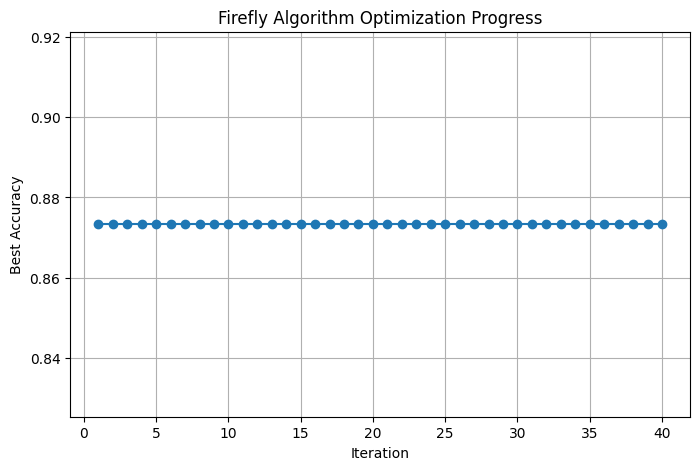

In [92]:
iterations = [i for i, acc in opt.history]
accuracies = [acc for i, acc in opt.history]

plt.figure(figsize=(8,5))
plt.plot(iterations, accuracies, marker='o')
plt.title("Firefly Algorithm Optimization Progress")
plt.xlabel("Iteration")
plt.ylabel("Best Accuracy")
plt.grid(True)
plt.show()

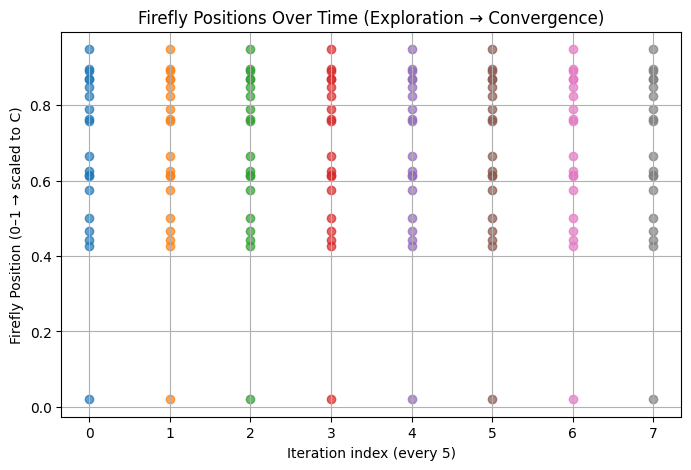

In [93]:
plt.figure(figsize=(8,5))
for idx, pos in enumerate(opt.positions[::5]):  # plot every 5 iterations
    plt.scatter([idx]*len(pos), pos, alpha=0.7)

plt.title("Firefly Positions Over Time (Exploration → Convergence)")
plt.xlabel("Iteration index (every 5)")
plt.ylabel("Firefly Position (0–1 → scaled to C)")
plt.grid(True)
plt.show()